In [1]:
import logging

import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import ILSVRC2014Sample, to_np, to_tensor, CUDA, VGG

logging.getLogger("PIL").setLevel(logging.INFO)

In [2]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

In [3]:
ilsvrc = ILSVRC2014Sample(40)

In [4]:
idx = 16
img = ilsvrc.data[idx][None, ...]
label = ilsvrc.labels[idx]

predicted_id = to_np(vgg.predict(to_tensor(img)))[0]

print(
    "Predicted: %s (correct: %s)"
    % (ilsvrc.id_to_desc[predicted_id], ilsvrc.label_to_desc[label])
)

num_integration_points = 300

batch_size = 20

assert (num_integration_points % batch_size) == 0

weights = np.linspace(0.0, 1.0, num_integration_points).astype("float32")[
    :, None, None, None
]
grads = []

for i in range(0, num_integration_points, batch_size):
    # TODO: batch contains a subset of images interpolating between the all gray image and the selected image
    batch = weights[i : i + batch_size] * img + (1.0 - weights[i : i + batch_size]) * (np.zeros_like(img) + 0.5)
    batch = to_tensor(batch, requires_grad=True)

    # TODO: Get the probabilities for the correct class
    prediction = torch.sum(vgg.probabilities(batch)[:, predicted_id])
    # And backpropagate towards the input
    prediction.backward()
    grads.append(to_np(batch.grad))

grads = np.concatenate(grads, axis=0)

importance_scores = np.abs(grads.sum((0, -1)))

Predicted: axolotl, mud puppy, Ambystoma mexicanum (correct: sea anemone, anemone)


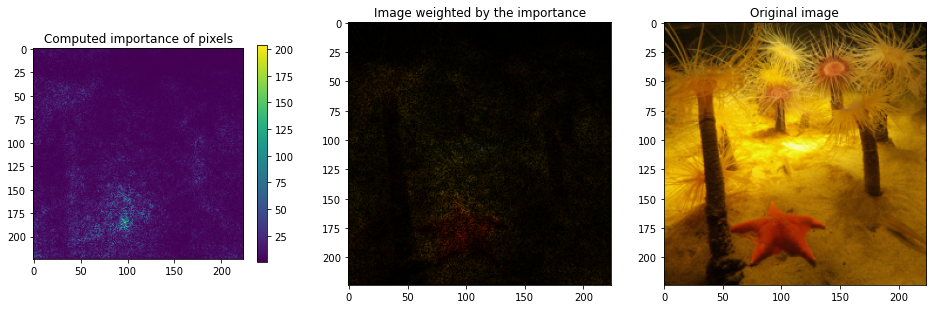

In [5]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
plt.imshow(importance_scores, cmap="viridis")
plt.colorbar(shrink=0.4)
plt.title("Computed importance of pixels")
plt.grid(False)

plt.subplot(1, 3, 2)
# normalize the scores to be <=1
w = importance_scores / importance_scores.max()
w = w ** 0.7  # a little gamma correction may make the image prettier
plt.imshow(img[0] * w[:, :, None])
plt.title("Image weighted by the importance")
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(img[0])
plt.title("Original image")
plt.grid(False)

In [6]:
def explain(img_idx):
    img = ilsvrc.data[img_idx][None, ...]
    label = ilsvrc.labels[img_idx]

    predicted_id = to_np(vgg.predict(to_tensor(img)))[0]

    print(
        "Predicted: %s (correct: %s)"
        % (ilsvrc.id_to_desc[predicted_id], ilsvrc.label_to_desc[label])
    )

    num_integration_points = 300

    batch_size = 20

    assert (num_integration_points % batch_size) == 0

    weights = np.linspace(0.0, 1.0, num_integration_points).astype("float32")[
        :, None, None, None
    ]
    grads = []

    for i in range(0, num_integration_points, batch_size):
        # TODO: batch contains a subset of images interpolating between the all gray image and the selected image
        batch = weights[i : i + batch_size] * img + (1.0 - weights[i : i + batch_size]) * (np.zeros_like(img) + 0.5)
        batch = to_tensor(batch, requires_grad=True)

        # TODO: Get the probabilities for the correct class
        prediction = torch.sum(vgg.probabilities(batch)[:, predicted_id])
        # And backpropagate towards the input
        prediction.backward()
        grads.append(to_np(batch.grad))

    grads = np.concatenate(grads, axis=0)

    importance_scores = np.abs(grads.sum((0, -1)))
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(importance_scores, cmap="viridis")
    plt.colorbar(shrink=0.4)
    plt.title("Computed importance of pixels")
    plt.grid(False)

    plt.subplot(1, 3, 2)
    # normalize the scores to be <=1
    w = importance_scores / importance_scores.max()
    w = w ** 0.7  # a little gamma correction may make the image prettier
    plt.imshow(img[0] * w[:, :, None])
    plt.title("Image weighted by the importance")
    plt.grid(False)

    plt.subplot(1, 3, 3)
    plt.imshow(img[0])
    plt.title("Original image")
    plt.grid(False)

Predicted: sea snake (correct: sea snake)
Predicted: ski (correct: alp)
Predicted: Shetland sheepdog, Shetland sheep dog, Shetland (correct: Shetland sheepdog, Shetland sheep dog, Shetland)
Predicted: soup bowl (correct: soup bowl)
Predicted: crib, cot (correct: cradle)
Predicted: night snake, Hypsiglena torquata (correct: garter snake, grass snake)


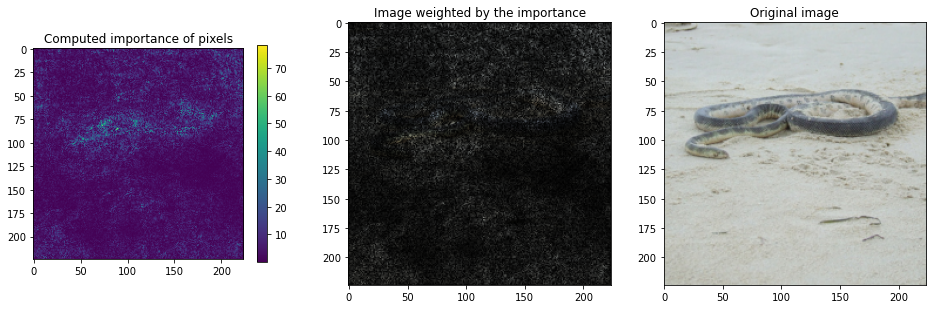

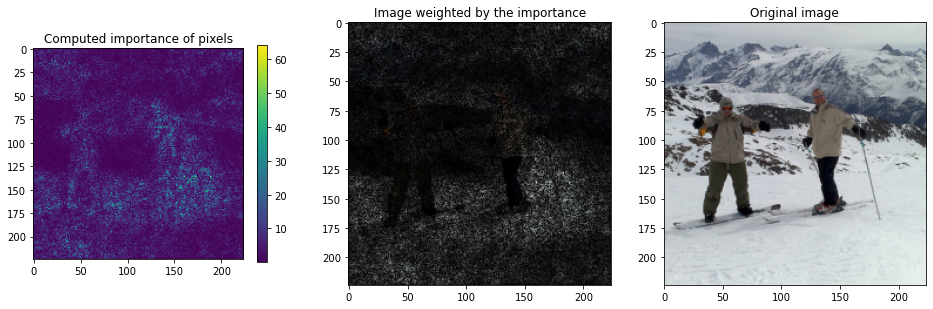

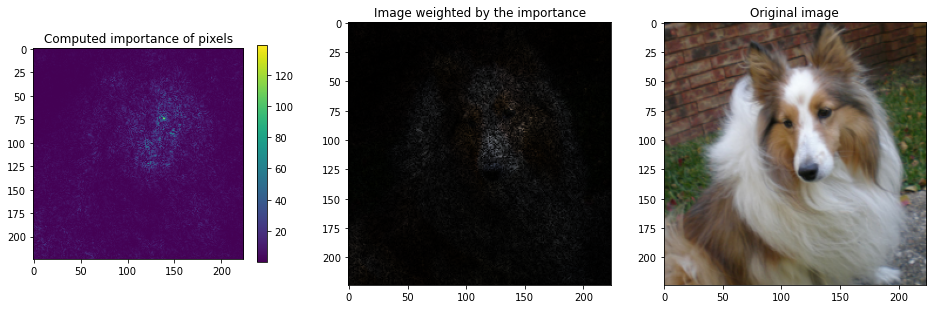

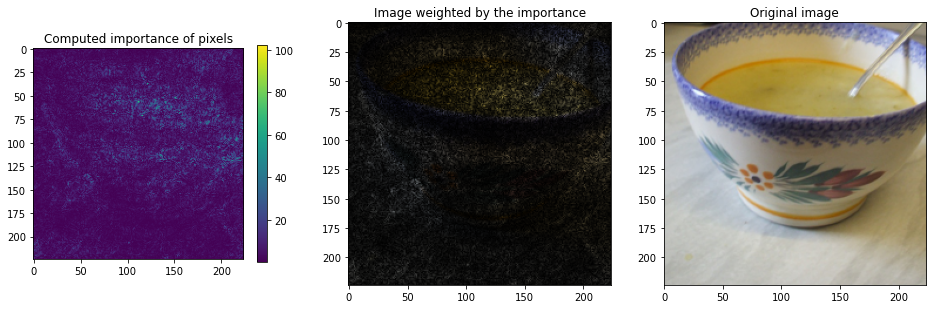

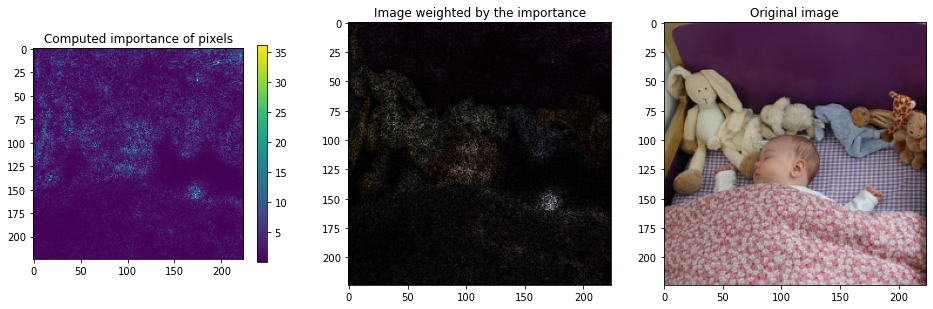

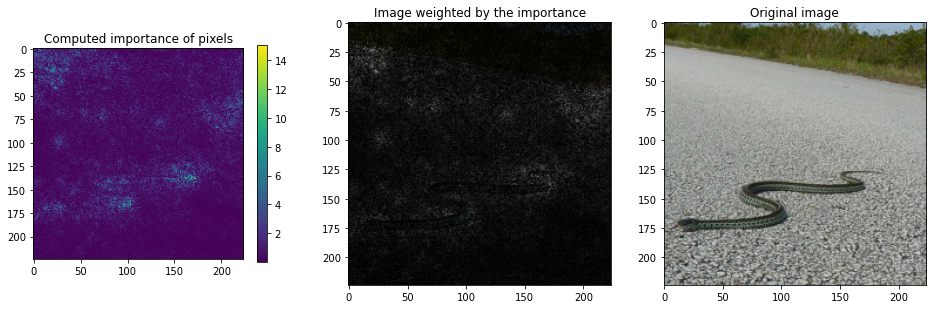

In [8]:
for img_idx in range(6):
    explain(img_idx)